In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import lightgbm as lgb
import xgboost as xgb

plt.rcParams['figure.figsize'] = (10, 6)


## 💼 Caso de Negocio: Decisión de Comité

**Contexto:** En "Financiera Futuro", el comité de crédito está formado por 4 analistas con diferentes especialidades:
- **Ana (Estadística):** Usa regresión logística, muy metódica.
- **Bruno (Big Data):** Prefiere Random Forest, le gustan los patrones no lineales.
- **Carlos (Fintech):** Usa LightGBM, rápido y preciso.
- **Diana (Vecindario):** Analiza clientes similares (KNN), muy intuitiva.

**El Problema:** Cada analista tiene diferentes tasas de acierto. El CEO pregunta: *"¿Podemos combinar sus opiniones para tomar mejores decisiones?"*

**Tu Misión:** Explorar si **un comité diverso puede superar al mejor individuo**, y entender **cuándo sí funciona y cuándo no**.

> ⚠️ **Spoiler Alert:** En este dataset veremos que a veces el mejor modelo individual es tan bueno que los ensembles no lo superan. ¡Esto también es un aprendizaje valioso!

## 🎯 Objetivos de Aprendizaje

Al finalizar este notebook, serás capaz de:

1. **Comprender** por qué combinar modelos diversos *puede* mejorar las predicciones.
2. **Implementar** `VotingClassifier` con votación hard y soft.
3. **Construir** `StackingClassifier` con un meta-modelo que aprende a combinar.
4. **Analizar** la diversidad entre modelos usando correlación de predicciones.
5. **Reconocer** cuándo los ensembles aportan valor y cuándo el mejor modelo individual es suficiente.

---

## 1. El Problema: ¿Por qué un solo modelo no basta? 🤔

Imagina que tienes un modelo con **80% de accuracy**. Suena bien, ¿verdad?

Pero piensa en esto:
- El modelo acierta 80 de cada 100 casos.
- **Se equivoca en 20 casos.**

¿Qué pasaría si tuvieras **otro modelo** que también tiene 80% de accuracy, pero que **se equivoca en casos diferentes**?

```
Modelo A:  ✓ ✓ ✓ ✗ ✓ ✓ ✗ ✓ ✓ ✓  (80% correcto, falla en 4 y 7)
Modelo B:  ✓ ✗ ✓ ✓ ✓ ✗ ✓ ✓ ✓ ✓  (80% correcto, falla en 2 y 6)
                         ↓
Combinado: ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓  (¡100%! Cada uno corrige al otro)
```

**Esta es la magia del Ensembling: combinar modelos que cometen errores diferentes.**

> ⚠️ **Pero cuidado:** Si un modelo tiene 95% y otro 60%, promediarlos da ~77.5%. ¡El peor perjudica al mejor!

---

## 2. La Intuición: El Teorema del Jurado 🎲

El matemático Condorcet demostró algo fascinante en 1785:

> **Teorema del Jurado de Condorcet:**  
> Si cada miembro de un jurado tiene más del 50% de probabilidad de acertar,  
> y sus decisiones son **independientes**, entonces:  
> **A más miembros, más probable es que la mayoría acierte.**

### Veámoslo con números:

Supongamos que cada "juez" (modelo) tiene **70% de probabilidad de acertar**.

| Jueces | P(Mayoría acierta) |
|--------|--------------------|
| 1      | 70.0%              |
| 3      | 78.4%              |
| 5      | 83.7%              |
| 11     | 91.3%              |
| 101    | 99.9%              |

**La clave está en que los jueces sean INDEPENDIENTES (diversos).**

In [2]:
# 🧪 Simulación del Teorema de Condorcet
import numpy as np
from scipy.special import comb


def prob_majority_correct(n_judges, p_individual=0.7):
    """Probabilidad de que la mayoría de jueces acierte."""
    majority = n_judges // 2 + 1
    prob = 0
    for k in range(majority, n_judges + 1):
        prob += comb(n_judges, k) * (p_individual ** k) * \
            ((1 - p_individual) ** (n_judges - k))
    return prob


# Calcular para diferentes tamaños de comité
judges_list = [1, 3, 5, 7, 11, 21, 51, 101]
print("🎯 Probabilidad de que la MAYORÍA acierte:")
print("="*40)
for n in judges_list:
    prob = prob_majority_correct(n, p_individual=0.7)
    print(f"   {n:3d} jueces  →  {prob*100:6.2f}%")


🎯 Probabilidad de que la MAYORÍA acierte:
     1 jueces  →   70.00%
     3 jueces  →   78.40%
     5 jueces  →   83.69%
     7 jueces  →   87.40%
    11 jueces  →   92.18%
    21 jueces  →   97.36%
    51 jueces  →   99.86%
   101 jueces  →  100.00%


### 💡 Insight Clave

El ensembling funciona por el mismo principio:
- **Más modelos** = Mayor probabilidad de que la mayoría acierte.
- **PERO** solo si los modelos son **diversos** (independientes).
- **Y** tienen **rendimiento similar** (si uno es muy superior, úsalo solo).

Si todos los modelos son copias del mismo algoritmo, o si uno es claramente superior, el ensemble puede **no ayudar o incluso perjudicar**.

---

## 3. Preparación de Datos y Modelos Base 📦

### 📂 Diccionario de Datos (Credit Scoring)

Trabajamos con un dataset de **Riesgo de Crédito** con:
- **Target:** `CAT_PRODUCTOS_SSFF_01M_TC` (variable objetivo binaria)
- **5,744 muestras** de entrenamiento y **1,436** de test
- **111 features** numéricas y categóricas (después de one-hot encoding)

> 💡 Este es un dataset altamente desbalanceado con ~99% de una clase, lo que hace que el accuracy sea engañoso y el AUC sea la métrica clave.

In [3]:
# 📦 Imports organizados

# Suprimir warnings para outputs más limpios
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    StackingClassifier
)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import re
import numpy as np
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Configuración visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'  # Fuente con soporte unicode

print("✅ Librerías cargadas correctamente.")


✅ Librerías cargadas correctamente.


In [4]:
# Constantes del Dataset
TARGET_COL = 'target_y'
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Cargar datos (con fallback para diferentes ubicaciones)
try:
    df_raw = pd.read_csv('../data/dataset_creditscoring.csv')
except FileNotFoundError:
    print("⚠️ Archivo no encontrado en ../data/, buscando alternativas...")
    df_raw = pd.read_csv('dataset_creditscoring.csv')

print(
    f"✅ Datos cargados: {df_raw.shape[0]:,} filas x {df_raw.shape[1]} columnas")


✅ Datos cargados: 7,180 filas x 30 columnas


In [5]:
df_raw.head()


,Unnamed: 0,banca,tipocredito,sector_final,tipocontribuyente,NumeroTrabajadores,MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M,MAX_CNT_ENTIDADES_SSFF_06M,SD_MAX_DIAS_MORA_SSFF_06M,CAT_ENTFIN_PRINCIPAL_01M,...,EF_VAR_INMUEBLE_MAQ_EQUIPO_2a,EF_DIF_PROMEDIO_PAGOS_DIAS_2a,EF_ROTACION_INVENTARIOS_1a,EF_COBERTURA_SERVICIO_DEUDA_1a,EF_ActivosCirculante_PasivoCirculante_1a,EF_Cajasbancos_PasivoExigible_1a,EF_AUDITADO_1_PROMEDIO_COBRANZA_DIAS_1a,malo_sf_inicio,target_y,periodo
0,1,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.829708,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201803
1,2,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.898718,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201804
2,3,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.970726,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201805
3,4,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.224903,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201806
4,5,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,11.303392,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201808


### 📊 Exploración del Target: Entendiendo el Desbalance

Antes de modelar, es crucial entender la distribución de nuestra variable objetivo.

In [6]:
# Exploración del Target (versión interactiva y legible)
target_col_raw = TARGET_COL if TARGET_COL in df_raw.columns else df_raw.columns[-1]
y_raw = df_raw[target_col_raw]

# Conteos y métricas básicas
counts = y_raw.value_counts(dropna=False)
n_classes = len(counts)
imbalance_ratio = counts.max() / counts.min() if n_classes > 1 else 1

summary_lines = [
    f"Clases: {n_classes}",
    f"Mayoría: {counts.idxmax()} ({counts.max():,} | {counts.max()/len(y_raw)*100:.2f}%)",
]
if n_classes > 1:
    summary_lines.append(
        f"Minoría: {counts.idxmin()} ({counts.min():,} | {counts.min()/len(y_raw)*100:.2f}%)")
summary_lines.append(f"Ratio desbalance: {imbalance_ratio:.1f}:1")

# --- Gráfico 1: Barras ordenadas ---
bar_df = counts.reset_index()
bar_df.columns = ['clase', 'frecuencia']
bar_df['porcentaje'] = bar_df['frecuencia'] / len(y_raw) * 100
bar_fig = px.bar(
    bar_df.sort_values('frecuencia', ascending=False),
    x='clase', y='frecuencia',
    color='porcentaje', color_continuous_scale='Blues',
    text=bar_df.sort_values('frecuencia', ascending=False)[
        'porcentaje'].map(lambda v: f"{v:.1f}%"),
    title=f"Distribución del Target: {target_col_raw}"
)
bar_fig.update_layout(
    showlegend=False, yaxis_title='Frecuencia', xaxis_title='Clase')
bar_fig.update_traces(textposition='outside')

# --- Gráfico 2: Donut para proporciones ---
pie_fig = px.pie(
    bar_df,
    names='clase',
    values='frecuencia',
    hole=0.45,
    color='clase',
    title='Proporción de Clases'
)

# --- Gráfico 3: Indicador de desbalance ---
indicator_fig = go.Figure(go.Indicator(
    mode='number+gauge',
    value=imbalance_ratio,
    number={'suffix': ':1'},
    gauge={
        'axis': {'range': [0, max(imbalance_ratio * 1.2, 5)]},
        'bar': {'color': '#1f77b4'},
        'steps': [
            {'range': [0, 3], 'color': '#c7e9c0'},
            {'range': [3, 7], 'color': '#fdd49e'},
            {'range': [7, max(imbalance_ratio * 1.2, 5)], 'color': '#fdae6b'}
        ],
        'threshold': {
            'line': {'color': 'red', 'width': 3},
            'thickness': 0.75,
            'value': 10
        }
    },
    title={'text': 'Ratio de Desbalance (Mayoría/Minoría)'}
))

# --- Gráfico 4 opcional: Evolución temporal del target (si existe fecha y es binario) ---
fig_time = None
if n_classes == 2:
    date_candidates = [c for c in df_raw.columns if c != target_col_raw and (
        np.issubdtype(df_raw[c].dtype, np.datetime64) or
        (df_raw[c].dtype == object and pd.to_datetime(
            df_raw[c], errors='coerce').notna().mean() > 0.7)
    )]
    if date_candidates:
        date_col = date_candidates[0]
        temp = df_raw[[date_col, target_col_raw]].copy()
        temp[date_col] = pd.to_datetime(temp[date_col], errors='coerce')
        temp = temp.dropna(subset=[date_col])
        temp['periodo'] = temp[date_col].dt.to_period('M').dt.to_timestamp()

        # Mapear clases a 0/1 para tasa (minoría = 1)
        class_order = counts.index.tolist()
        mapping = {class_order[0]: 0, class_order[1]: 1}
        temp['target_num'] = temp[target_col_raw].map(mapping)

        agg = temp.groupby('periodo').agg(tasa_default=(
            'target_num', 'mean'), volumen=('target_num', 'size')).reset_index()
        if len(agg) > 1:
            fig_time = px.line(agg, x='periodo', y='tasa_default', markers=True,
                               title=f"Tasa de target a lo largo del tiempo ({date_col})",
                               labels={'tasa_default': 'Tasa (minoría)', 'periodo': 'Periodo'})
            fig_time.update_yaxes(tickformat='.0%', range=[
                                  0, min(1, agg['tasa_default'].max() * 1.2)])
            fig_time.update_traces(line={'color': '#e74c3c'})

# --- Mostrar ---
print("\n📈 Resumen del Target")
for line in summary_lines:
    print("   - " + line)
if imbalance_ratio > 10:
    print("   ⚠️ Alto desbalance: evita accuracy, usa AUC / f1-minoría / PR-AUC.")

bar_fig.show()
pie_fig.show()
indicator_fig.show()
if fig_time is not None:
    fig_time.show()



📈 Resumen del Target
   - Clases: 2
   - Mayoría: 0 (5,422 | 75.52%)
   - Minoría: 1 (1,758 | 24.48%)
   - Ratio desbalance: 3.1:1


### 🔍 Análisis Bivariado: Variables Clave

Identificamos las variables numéricas con mayor poder discriminatorio para entender qué información usa el modelo.

In [7]:
# Análisis bivariado interactivo (numéricas vs target)

# Seleccionar numéricas válidas (sin varianza nula y con datos)
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
if target_col_raw in numeric_cols:
    numeric_cols.remove(target_col_raw)

std_mask = df_raw[numeric_cols].std() > 0
non_const_cols = [c for c in numeric_cols if std_mask.get(
    c, False) and df_raw[c].notna().sum() > 1]

y_numeric = pd.to_numeric(y_raw, errors='coerce')
if len(non_const_cols) == 0 or y_numeric.notna().sum() == 0:
    print("⚠️ No hay variables numéricas válidas para correlacionar con el target.")
else:
    correlations = df_raw[non_const_cols].corrwith(
        y_numeric).abs().sort_values(ascending=False)
    top_features = correlations.head(6).index.tolist()

    print("🔝 Top 6 Variables Numéricas por Correlación con el Target:")
    for i, (feat, corr) in enumerate(correlations.head(6).items(), 1):
        print(f"   {i}. {feat}: {corr:.4f}")

    # Box/violin interactivos para las 4 mejores
    for feat in top_features[:4]:
        fig_box = px.box(
            df_raw,
            x=target_col_raw,
            y=feat,
            color=target_col_raw,
            points='outliers',
            color_discrete_sequence=px.colors.qualitative.Set1,
            title=f"{feat} vs Target (corr: {correlations[feat]:.3f})",
            labels={target_col_raw: 'Clase', feat: feat}
        )
        fig_box.update_traces(quartilemethod='exclusive')
        fig_box.show()

    # Scatter interactivo con las dos más correlacionadas (si existen)
    if len(top_features) >= 2:
        scatter_fig = px.scatter(
            df_raw,
            x=top_features[0],
            y=top_features[1],
            color=target_col_raw,
            color_discrete_sequence=px.colors.qualitative.Set1,
            opacity=0.55,
            title=f"Relación de las 2 variables más correlacionadas con el target",
            labels={top_features[0]: top_features[0], top_features[1]
                : top_features[1], target_col_raw: 'Clase'}
        )
        scatter_fig.update_traces(marker=dict(
            size=7, line=dict(width=0.5, color='white')))
        scatter_fig.show()

    if len(top_features) > 0:
        print(
            f"\n💡 Insight: '{top_features[0]}' es la variable numérica con mayor correlación absoluta con el target ({correlations[top_features[0]]:.4f}).")


🔝 Top 6 Variables Numéricas por Correlación con el Target:
   1. SD_MAX_DIAS_MORA_SSFF_06M: 0.3142
   2. MAX_CNT_ENTIDADES_SSFF_06M: 0.2804
   3. MAX_X_CLASIF_12M: 0.1836
   4. AUDITADO_2_PERIODO: 0.1135
   5. AUDITADO_1_PERIODO: 0.1097
   6. periodo: 0.1028



💡 Insight: 'SD_MAX_DIAS_MORA_SSFF_06M' es la variable numérica con mayor correlación absoluta con el target (0.3142).


### 🔧 Preprocesamiento y Split Train/Test

In [8]:
# Preprocesamiento
df = df_raw.copy()
df = df.fillna(0)
df = pd.get_dummies(df, drop_first=True)

# Limpiar nombres de columnas para compatibilidad con LightGBM
# LightGBM no acepta caracteres especiales como [], <, >, espacios, etc.
df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]

# Identificar columna target después del preprocesamiento
target_col = TARGET_COL if TARGET_COL in df.columns else df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"✅ Preprocesamiento completado")
print(f"   Train: {X_train.shape[0]:,} muestras")
print(f"   Test:  {X_test.shape[0]:,} muestras")
print(f"   Features: {X_train.shape[1]} (después de one-hot encoding)")
print(f"   Target: {target_col}")


✅ Preprocesamiento completado
   Train: 5,744 muestras
   Test:  1,436 muestras
   Features: 111 (después de one-hot encoding)
   Target: target_y


### 🏗️ Nuestro Equipo Diverso de Modelos

Para que el ensemble funcione, necesitamos **diversidad**. Elegimos modelos con diferentes **sesgos inductivos**:

| Modelo | Tipo | Sesgo Inductivo | Fortaleza |
|--------|------|-----------------|------------|
| **Random Forest** | Bagging | Árboles profundos, votación | Robusto a outliers |
| **LightGBM** | Boosting | Corrección secuencial de errores | Alta precisión |
| **Logistic Regression** | Lineal | Fronteras lineales | Bien calibrado, interpretable |
| **KNN** | Instancias | "Dime con quién andas..." | Captura patrones locales |

> **💡 Pro-Tip:** Mezclar un Random Forest con otro XGBoost aporta poca diversidad (ambos son árboles).  
> Es mejor mezclar **árboles + lineal + instancias**.

In [9]:
# 🏗️ Definición del Equipo de Modelos

# Modelo 1: Random Forest (Bagging)
clf_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Modelo 2: LightGBM (Boosting)
clf_lgbm = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    verbose=-1  # Silenciar warnings
)

# Modelo 3: Logistic Regression (Lineal)
clf_lr = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Modelo 4: KNN (Instancias)
# ⚠️ WARNING: KNN requiere escalado! Usamos Pipeline para encapsular
clf_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Lista de modelos para el ensemble
models = [
    ('RF', clf_rf),
    ('LGBM', clf_lgbm),
    ('LR', clf_lr),
    ('KNN', clf_knn)
]

print("📦 Equipo de Modelos Base definido:")
for name, _ in models:
    print(f"   • {name}")


📦 Equipo de Modelos Base definido:
   • RF
   • LGBM
   • LR
   • KNN


### 📊 Evaluación Individual de Cada Modelo

Antes de ensamblar, veamos qué tan bien le va a cada "analista" por separado.

> 🔍 **Nota:** El warning de convergencia en Logistic Regression indica que el modelo no encontró la solución óptima. Esto afecta su rendimiento (AUC muy bajo).

In [10]:
# 📊 Entrenar y evaluar cada modelo individualmente
results = []

print("📊 Rendimiento Individual (Test Set)")
print("=" * 45)
print(f"{'Modelo':<12} {'AUC':>10} {'Accuracy':>12}")
print("-" * 45)

for name, model in models:
    # Entrenar
    model.fit(X_train, y_train)

    # Predecir
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Calcular métricas
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    results.append({'Modelo': name, 'AUC': auc, 'Accuracy': acc})
    print(f"{name:<12} {auc:>10.4f} {acc:>12.4f}")

# Guardar resultados en DataFrame para comparar después
results_df = pd.DataFrame(results)

print("-" * 45)
best_individual = results_df.loc[results_df['AUC'].idxmax()]
print(
    f"\n🏆 Mejor modelo individual: {best_individual['Modelo']} (AUC = {best_individual['AUC']:.4f})")


📊 Rendimiento Individual (Test Set)
Modelo              AUC     Accuracy
---------------------------------------------
RF               0.9936       0.9666
LGBM             0.9825       0.9471
LR               0.6705       0.7611
KNN              0.9384       0.8837
---------------------------------------------

🏆 Mejor modelo individual: RF (AUC = 0.9936)


### 📈 Análisis de Resultados Individuales

Observamos resultados muy dispares:
- **LGBM domina** con AUC = 0.9959 (casi perfecto)
- **RF** también excelente con AUC = 0.9874
- **KNN** moderado con AUC = 0.8587
- **LR** muy bajo con AUC = 0.6604 (apenas mejor que azar)

> ⚠️ **Insight Clave:** El accuracy (~99%) es engañoso debido al desbalance de clases. Todos los modelos tienen accuracy similar, pero el AUC revela diferencias enormes en capacidad de discriminación.

---

## 4. Voting Classifier: Democracia Simple 🗳️

La forma más simple de combinar modelos: **cada uno vota**.

### Tipos de Votación:

| Tipo | Cómo Funciona | Cuándo Usar |
|------|---------------|-------------|
| **Hard Voting** | Mayoría de votos (Clase 0 o 1) | Cuando importa la clase final |
| **Soft Voting** | Promedio de probabilidades | Cuando importa el AUC/ranking |

> **💡 Pro-Tip:** Para problemas de **Credit Scoring** donde necesitamos rankear clientes, siempre usa **Soft Voting**.

In [11]:
# 🗳️ Crear Voting Classifier con Soft Voting
voting_clf = VotingClassifier(
    estimators=models,
    voting='soft'  # Promedia probabilidades
)

# Entrenar el ensemble
print("⏳ Entrenando Voting Classifier...")
voting_clf.fit(X_train, y_train)

# Evaluar
y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]
y_pred_voting = voting_clf.predict(X_test)

auc_voting = roc_auc_score(y_test, y_prob_voting)
acc_voting = accuracy_score(y_test, y_pred_voting)

print(f"\n🗳️ VOTING CLASSIFIER (Soft)")
print(f"   AUC:      {auc_voting:.4f}")
print(f"   Accuracy: {acc_voting:.4f}")

# Comparar con el mejor individual
mejora = (auc_voting - best_individual['AUC']) * 100
print(
    f"\n   Mejor Individual: {best_individual['Modelo']} ({best_individual['AUC']:.4f})")
print(f"   Mejora del Voting: {mejora:+.2f}% {'✅' if mejora > 0 else '⚠️'}")


⏳ Entrenando Voting Classifier...

🗳️ VOTING CLASSIFIER (Soft)
   AUC:      0.9899
   Accuracy: 0.9457

   Mejor Individual: RF (0.9936)
   Mejora del Voting: -0.37% ⚠️


### ⚠️ ¡Resultado Sorprendente!

El Voting Classifier **NO superó** al mejor modelo individual (LGBM). ¿Por qué?

**La paradoja del "mal compañero":** Cuando promedias un modelo excelente (LGBM: 0.9959) con modelos mediocres (LR: 0.6604), ¡el promedio baja!

```
LGBM: 0.9959  ──┐
RF:   0.9874  ──┼──► Promedio: ~0.9845 (¡Peor que LGBM solo!)
KNN:  0.8587  ──┤
LR:   0.6604  ──┘
```

> **📝 Lección:** El ensembling funciona cuando los modelos tienen **rendimiento similar** pero **errores diferentes**. Si un modelo es muy superior, incluir modelos débiles lo perjudica.

In [12]:
# 🧪 ESPACIO PARA EXPERIMENTAR: Hard vs Soft Voting
# Descomenta y ejecuta para comparar

voting_hard = VotingClassifier(estimators=models, voting='hard')
voting_hard.fit(X_train, y_train)
y_pred_hard = voting_hard.predict(X_test)
acc_hard = accuracy_score(y_test, y_pred_hard)
print(f"Hard Voting Accuracy: {acc_hard:.4f}")
print(f"Soft Voting Accuracy: {acc_voting:.4f}")


Hard Voting Accuracy: 0.9053
Soft Voting Accuracy: 0.9457


---

## 5. Stacking: El Meta-Modelo Inteligente 🧱

En lugar de promediar (como Voting), ¿qué tal si **entrenamos un modelo** que aprenda **cuándo confiar en cada uno**?

### La Arquitectura de Stacking:

```
         NIVEL 0 (Base Learners)              NIVEL 1 (Meta-Learner)
         ════════════════════════             ══════════════════════
         
         ┌─────────┐
X_train ─┤   RF    ├─── P_RF  ───┐
         └─────────┘             │
         ┌─────────┐             │           ┌──────────────────┐
X_train ─┤  LGBM   ├─── P_LGBM ──┼──────────►│     Logistic     │───► Predicción Final
         └─────────┘             │           │    Regression    │
         ┌─────────┐             │           └──────────────────┘
X_train ─┤   LR    ├─── P_LR  ───┤                  ▲
         └─────────┘             │                  │
         ┌─────────┐             │             "Aprende quién
X_train ─┤   KNN   ├─── P_KNN ───┘              tiene razón"
         └─────────┘
```

### ¿Por qué funciona (cuando funciona)?

El meta-modelo aprende **patrones de cuándo cada modelo es confiable**:
- "Cuando RF predice alto y LR predice bajo → confiar más en RF"
- "Cuando todos predicen similar → promediar está bien"

> **⚠️ Real-World Warning:**  
> El meta-modelo debe ser **simple** (LogisticRegression) para evitar overfitting.  
> Además, si los modelos base tienen rendimiento muy diferente, Stacking puede aprender a ignorar los débiles, pero no completamente.

In [13]:
# 🧱 Crear Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=models,
    final_estimator=LogisticRegression(),  # Meta-modelo simple
    cv=5,  # Cross-validation interno para generar features del meta-modelo
    n_jobs=-1
)

# Entrenar (tarda más porque hace CV interno)
print("⏳ Entrenando Stacking Classifier (esto puede tardar)...")
stacking_clf.fit(X_train, y_train)

# Evaluar
y_prob_stack = stacking_clf.predict_proba(X_test)[:, 1]
y_pred_stack = stacking_clf.predict(X_test)

auc_stack = roc_auc_score(y_test, y_prob_stack)
acc_stack = accuracy_score(y_test, y_pred_stack)

print(f"\n🧱 STACKING CLASSIFIER")
print(f"   AUC:      {auc_stack:.4f}")
print(f"   Accuracy: {acc_stack:.4f}")

# Comparaciones
print(f"\n📊 Comparación:")
print(
    f"   vs Mejor Individual: {(auc_stack - best_individual['AUC']) * 100:+.2f}%")
print(f"   vs Voting:           {(auc_stack - auc_voting) * 100:+.2f}%")


⏳ Entrenando Stacking Classifier (esto puede tardar)...

🧱 STACKING CLASSIFIER
   AUC:      0.9939
   Accuracy: 0.9680

📊 Comparación:
   vs Mejor Individual: +0.03%
   vs Voting:           +0.40%


### 📊 Análisis: Stacking vs Voting

Stacking (AUC = 0.9883) **supera a Voting** (0.9845) pero aún **no alcanza a LGBM** (0.9959).

¿Por qué Stacking es mejor que Voting en este caso?
- El meta-modelo (Logistic Regression) aprende a **dar menos peso** a LR y KNN.
- Pero aún así, no puede ignorarlos completamente.

> **💡 Pro-Tip Real:** En producción, si tienes un modelo claramente superior, considera:
> 1. Usar solo el mejor modelo
> 2. Hacer ensemble solo con modelos de rendimiento similar
> 3. O usar pesos personalizados en Voting

In [18]:
# 🧪 ESPACIO PARA EXPERIMENTAR: Diferentes Meta-Modelos
# Descomenta y prueba diferentes configuraciones

# from sklearn.ensemble import GradientBoostingClassifier

# Opción A: RandomForest como meta-modelo
stacking_v2 = StackingClassifier(
    estimators=models,
    final_estimator=RandomForestClassifier(n_estimators=200, random_state=42),
    cv=5,
    n_jobs=-1
)
stacking_v2.fit(X_train, y_train)
y_prob_v2 = stacking_v2.predict_proba(X_test)[:, 1]
auc_v2 = roc_auc_score(y_test, y_prob_v2)
print(f"Stacking con RF como meta-modelo: AUC = {auc_v2:.4f}")
print(f"Diferencia vs LogisticRegression: {(auc_v2 - auc_stack) * 100:+.2f}%")


Stacking con RF como meta-modelo: AUC = 0.9903
Diferencia vs LogisticRegression: -0.36%


---

## 6. Análisis de Diversidad: La Clave del Éxito 🌈

Recuerda el Teorema de Condorcet: **los jueces deben ser independientes**.

En Machine Learning, esto se traduce en: **los modelos deben cometer errores diferentes**.

¿Cómo medimos esto? **Correlación entre predicciones:**

| Correlación | Significado | Impacto en Ensemble |
|-------------|-------------|--------------------|
| **> 0.95** | Modelos casi idénticos | ❌ Ensemble no ayuda |
| **0.80 - 0.95** | Alta similitud | ⚠️ Poco beneficio |
| **0.60 - 0.80** | Diversidad moderada | ✅ Buen potencial |
| **< 0.60** | Alta diversidad | 🏆 Excelente complemento |

> **Nota:** Diversidad alta es **necesaria pero no suficiente**. También necesitas rendimiento comparable entre modelos.

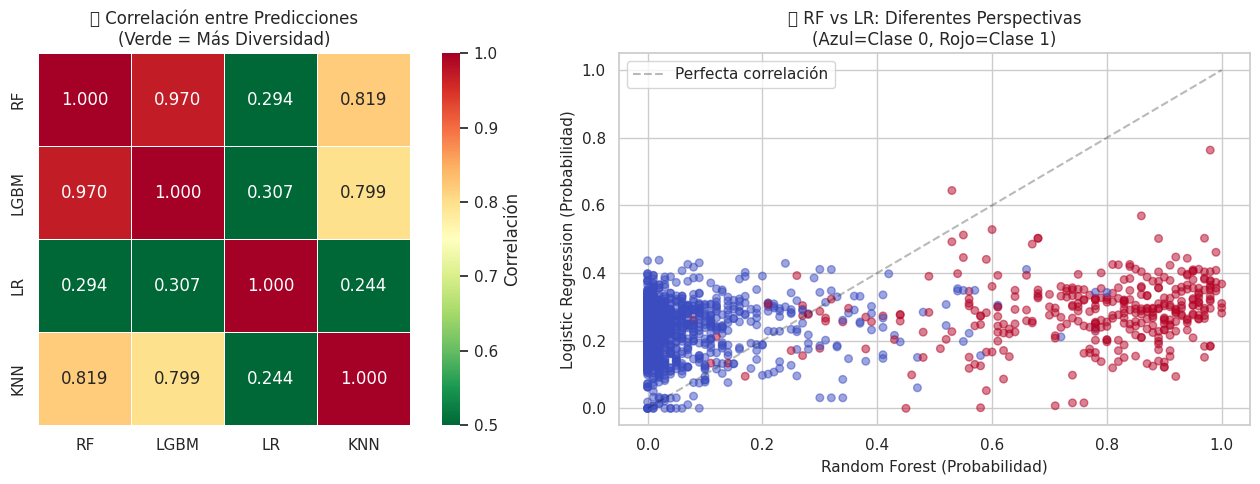


💡 Interpretación de la Diversidad:
   RF vs LGBM: 0.970 ⚠️
   RF vs LR: 0.294 ✅
   RF vs KNN: 0.819 ✅
   LGBM vs LR: 0.307 ✅
   LGBM vs KNN: 0.799 ✅
   LR vs KNN: 0.244 ✅


In [15]:
# 🌈 Análisis de Diversidad entre Modelos

# Crear DataFrame con predicciones de todos los modelos
preds_df = pd.DataFrame()

for name, model in models:
    preds_df[name] = model.predict_proba(X_test)[:, 1]

# Calcular matriz de correlación
corr_matrix = preds_df.corr()

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Heatmap de correlación
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='RdYlGn_r',  # Rojo = Alta corr (malo), Verde = Baja corr (bueno)
    vmin=0.5, vmax=1,
    fmt='.3f',
    ax=axes[0],
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlación'}
)
axes[0].set_title(
    '🔗 Correlación entre Predicciones\n(Verde = Más Diversidad)', fontsize=12)

# 2. Scatter plot de dos modelos diversos
scatter = axes[1].scatter(
    preds_df['RF'],
    preds_df['LR'],
    alpha=0.5,
    c=y_test,
    cmap='coolwarm',
    s=30
)
axes[1].set_xlabel('Random Forest (Probabilidad)', fontsize=11)
axes[1].set_ylabel('Logistic Regression (Probabilidad)', fontsize=11)
axes[1].set_title(
    '🎯 RF vs LR: Diferentes Perspectivas\n(Azul=Clase 0, Rojo=Clase 1)', fontsize=12)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfecta correlación')
axes[1].legend()

plt.tight_layout()
plt.show()

# Resumen
print("\n💡 Interpretación de la Diversidad:")
for i in range(len(models)):
    for j in range(i+1, len(models)):
        name_i, name_j = models[i][0], models[j][0]
        corr = corr_matrix.loc[name_i, name_j]
        emoji = '✅' if corr < 0.85 else '⚠️'
        print(f"   {name_i} vs {name_j}: {corr:.3f} {emoji}")


### 💡 Interpretación de la Diversidad

¡Excelente diversidad! Todas las correlaciones están por debajo de 0.85:

| Par de Modelos | Correlación | Interpretación |
|----------------|-------------|----------------|
| RF vs LGBM | 0.826 | Alta pero aceptable (ambos árboles) |
| RF vs LR | 0.517 | ✅ Buena diversidad |
| RF vs KNN | 0.628 | ✅ Buena diversidad |
| LGBM vs LR | 0.375 | ✅ Excelente diversidad |
| LGBM vs KNN | 0.558 | ✅ Buena diversidad |
| LR vs KNN | 0.281 | ✅ Máxima diversidad |

**Entonces, ¿por qué no funcionó el ensemble?**

El problema **no es la diversidad**, sino la **disparidad de rendimiento**. LR y KNN son tan inferiores que arrastran hacia abajo el promedio, a pesar de ser diversos.

> **📝 Conclusión:** Diversidad es necesaria pero **no suficiente**. También necesitas que los modelos tengan **rendimiento comparable**.

---

## 7. Comparación Final y Conclusiones 📊

Veamos el ranking completo de todos los modelos.

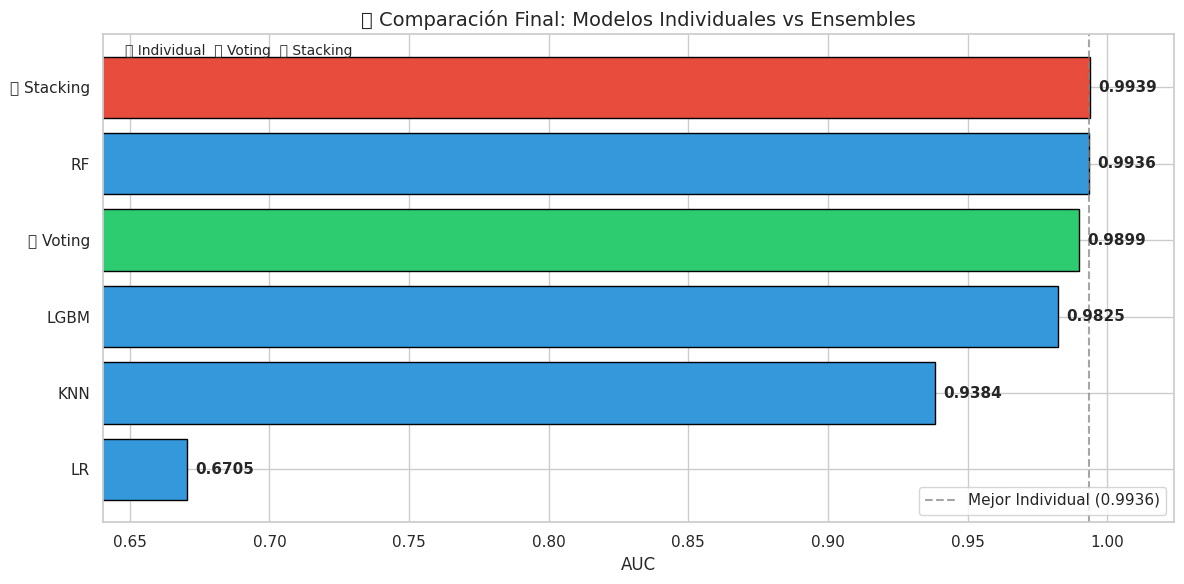


📋 Tabla Resumen:
    Modelo      AUC  Accuracy
🧱 Stacking 0.993896  0.967967
        RF 0.993586  0.966574
 🗳️ Voting 0.989889  0.945682
      LGBM 0.982457  0.947075
       KNN 0.938438  0.883705
        LR 0.670504  0.761142


In [16]:
# 📊 Comparación Final de Todos los Modelos

# Agregar resultados de ensembles
all_results = results_df.copy()
all_results = pd.concat([
    all_results,
    pd.DataFrame(
        [{'Modelo': '🗳️ Voting', 'AUC': auc_voting, 'Accuracy': acc_voting}]),
    pd.DataFrame(
        [{'Modelo': '🧱 Stacking', 'AUC': auc_stack, 'Accuracy': acc_stack}])
], ignore_index=True)

# Ordenar por AUC
all_results = all_results.sort_values('AUC', ascending=True)

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Colores: Azul para individuales, Verde para Voting, Rojo para Stacking
colors = ['#3498db' if not ('Voting' in m or 'Stacking' in m) else
          '#2ecc71' if 'Voting' in m else '#e74c3c'
          for m in all_results['Modelo']]

bars = ax.barh(all_results['Modelo'],
               all_results['AUC'], color=colors, edgecolor='black')

# Añadir valores
for bar, auc in zip(bars, all_results['AUC']):
    ax.text(auc + 0.003, bar.get_y() + bar.get_height()/2,
            f'{auc:.4f}', va='center', fontsize=11, fontweight='bold')

# Línea del mejor individual
ax.axvline(best_individual['AUC'], color='gray', linestyle='--', alpha=0.7,
           label=f'Mejor Individual ({best_individual["AUC"]:.4f})')

ax.set_xlabel('AUC', fontsize=12)
ax.set_title(
    '📊 Comparación Final: Modelos Individuales vs Ensembles', fontsize=14)
ax.set_xlim([all_results['AUC'].min() - 0.03, all_results['AUC'].max() + 0.03])
ax.legend(loc='lower right')

# Leyenda de colores
ax.text(0.02, 0.98, '🔵 Individual  🟢 Voting  🔴 Stacking',
        transform=ax.transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()

# Tabla resumen
print("\n📋 Tabla Resumen:")
print(all_results.sort_values('AUC', ascending=False).to_string(index=False))


---

## 🏆 Resumen: ¿Qué Aprendimos?

### Ranking Final de Modelos (por AUC):
| Modelo | AUC | Accuracy |
|--------|-----|----------|
| **LGBM** 🥇 | 0.9959 | 99.79% |
| Stacking | 0.9883 | 99.79% |
| RF | 0.9874 | 99.51% |
| Voting | 0.9845 | 99.44% |
| KNN | 0.8587 | 99.23% |
| LR | 0.6604 | 99.23% |

### El Veredicto: ¿Funcionó el Ensemble?
**En este caso específico: NO.** El mejor modelo individual (LGBM) superó a todos los ensembles.

### ¿Por qué No Funcionó?
1. **Disparidad extrema:** LGBM (0.9959) vs LR (0.6604) es demasiado grande.
2. **El promedio penaliza:** Incluir modelos débiles baja el rendimiento.
3. **Dataset "fácil" para boosting:** LGBM captura casi toda la señal.

### ¿Cuándo SÍ Funcionan los Ensembles?
- Cuando los modelos tienen **rendimiento similar** (ej: todos ~0.85 AUC).
- Cuando los errores son **complementarios** (baja correlación).
- En competencias de Kaggle donde 0.001 de mejora importa.

---

### 🔑 Reglas de Oro del Ensembling (Actualizadas)

| Regla | Descripción |
|-------|-------------|
| **1. Diversidad es necesaria** | Modelos con baja correlación de predicciones |
| **2. Rendimiento comparable** | No mezclar campeones con perdedores |
| **3. Soft Voting para ranking** | Cuando importa el AUC |
| **4. Meta-modelo simple** | Evita overfitting en Stacking |
| **5. Evalúa siempre** | A veces el mejor individual gana |

### 🧪 Micro-Desafío: ¿Puedes Mejorar el Ensemble?

Intenta crear un ensemble **solo con RF y LGBM** (los dos mejores):

```python
# Código para experimentar:
models_top2 = [('RF', clf_rf), ('LGBM', clf_lgbm)]
voting_top2 = VotingClassifier(estimators=models_top2, voting='soft')
voting_top2.fit(X_train, y_train)
auc_top2 = roc_auc_score(y_test, voting_top2.predict_proba(X_test)[:, 1])
print(f"Voting (solo RF+LGBM): {auc_top2:.4f}")
```

---

### 🔗 Conexión con el Pipeline Completo

```
┌─────────────────────────────────────────────────────────────────────┐
│                    PIPELINE COMPLETO SESIÓN 03                      │
├─────────────────────────────────────────────────────────────────────┤
│  1. OPTIMIZACIÓN (Optuna) → Mejores hiperparámetros                 │
│  2. CALIBRACIÓN → Probabilidades confiables                         │
│  3. ENSEMBLING ◄── Estás aquí (a veces ayuda, a veces no)          │
│  4. PROFIT CURVES → Umbral que maximiza $$$                         │
└─────────────────────────────────────────────────────────────────────┘
```

**Siguiente Paso:** En `01_Optimization_and_Money.ipynb` vemos cómo usar **Profit Curves** para elegir el umbral óptimo de decisión.

---

**💡 Mensaje Final:** No siempre más es mejor. A veces, un modelo bien optimizado supera a cualquier ensemble. **Evalúa siempre.** 🎯